### Case Study - Fig 5B

In [ ]:
import pickle
import pandas as pd
from data_prepare import *
from functools import reduce

with open("./CombinationSplit/results.pickle", "rb") as f:
    results = pickle.load(f)
models = results.keys()

writer = pd.ExcelWriter("./CaseStudy-Fig5B/Results.xlsx")
for model in models:
    train_combs = results[model]['train_combs']
    test_combs = reduce(lambda x,y: x+y, [results[model]["cat_test_combs"],
                                          results[model]["subs_test_combs"],
                                          results[model]["catsubs_test_combs"]])
    catalysts = list(set([x.split("_")[0] + "_" + x.split("_")[1] for x in test_combs]))
    train_catalysts = list(set([x.split("_")[0] + "_" + x.split("_")[1] for x in train_combs]))
    test_catalysts = [cat for cat in catalysts if cat not in train_catalysts]

    reactions = pd.Series(train_combs + test_combs)
    observed_data = pd.Series(np.concatenate((results[model]["train_observed_ddG"],
                                              results[model]["cat_observed_ddG"],
                                              results[model]["subs_observed_ddG"],
                                              results[model]["catsubs_observed_ddG"])), index=reactions)
    predict_data = pd.Series(np.concatenate((results[model]["train_predict_ddG"],
                                             results[model]["cat_predict_ddG"],
                                             results[model]["subs_predict_ddG"],
                                             results[model]["catsubs_predict_ddG"])), index=reactions)
    observed_ddGs = dict([(cat, observed_data[reactions[reactions.apply(lambda x: cat in x)]].mean()) for cat in test_catalysts])
    predict_ddGs = dict([(cat, predict_data[reactions[reactions.apply(lambda x: cat in x)]].mean()) for cat in test_catalysts])

    df = pd.DataFrame({"Observed": observed_ddGs, "Predicted": predict_ddGs})
    df = df.sort_values(by="Observed",ascending=False)
    df.to_excel(writer, sheet_name=model)
writer.save()

### Case Study - Fig S10

,R^2,MAD_train,MAD_cat,MAD_subs,MAD_catsubs
RF,0.995357,0.006094,0.018868,0.018108,0.027472
LASSO,0.974699,0.071257,0.078048,0.099135,0.156077
RIDGE,0.975236,0.048725,0.061728,0.119331,0.132689
LASSOLARS,0.971677,0.070553,0.073005,0.129008,0.116860
SVR_POLY2,0.468626,0.083496,0.362133,0.504189,0.601471
SVR_RBF,0.985744,0.016060,0.044219,0.086743,0.100949
SVR_LINEAR,0.965285,0.051959,0.068254,0.096675,0.107560
EN,0.972131,0.050206,0.064280,0.135536,0.149958
KR_RBF,0.689169,0.088631,0.182773,0.449040,0.533871
KR_LINEAR,-1.328061,0.048700,1.037402,1.168238,1.175932


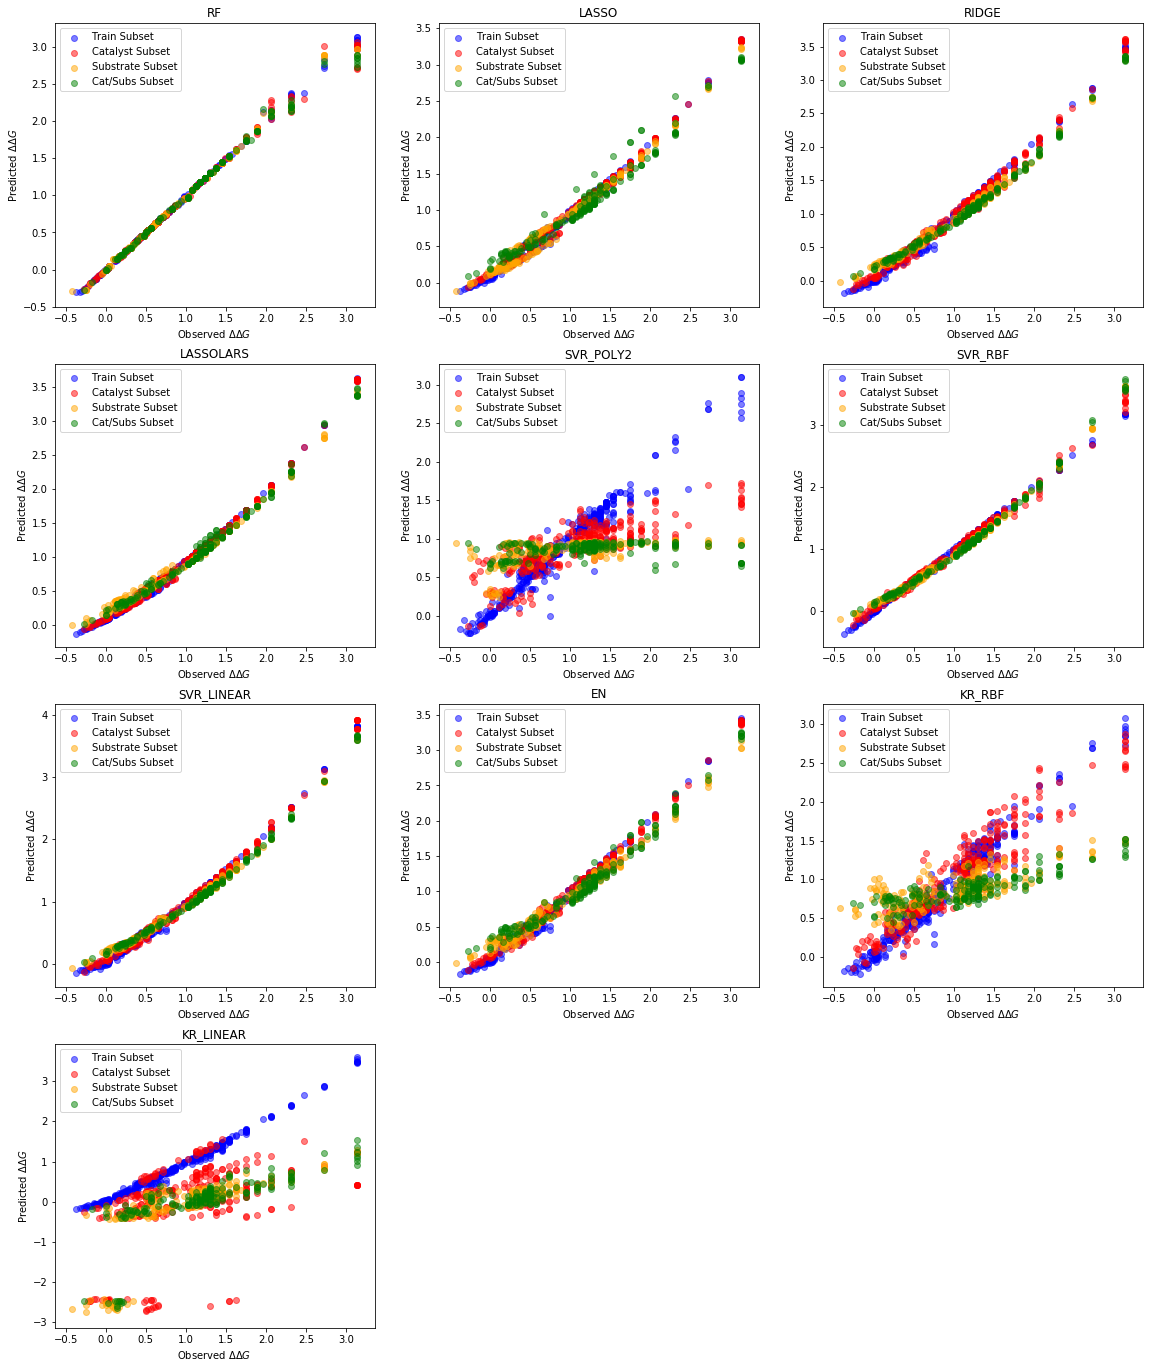

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

with open("./CombinationSplit/results.pickle", "rb") as f:
    datas = pickle.load(f)

def MAD(y, y_hat):
    return abs(y_hat - y).mean()

def R_square(y, y_hat):
    y_bar = y.mean()
    SSE = ((y - y_hat) ** 2).sum()
    SST = ((y - y_bar) ** 2).sum()
    return 1 - SSE / SST

models = list(datas.keys())
fig = plt.figure(figsize=(19.5, math.ceil(len(models)/3) * 6))
gs = fig.add_gridspec(math.ceil(len(models)/3), 3)
results = {}
for k in range(len(models)):
    model = models[k]
    data = datas[model]
    observed_train, predict_train = data['train_observed_ddG'], data['train_predict_ddG']
    MAD_train = MAD(observed_train, predict_train)

    observed_cat, predict_cat = data['cat_observed_ddG'], data['cat_predict_ddG']
    MAD_cat = MAD(observed_cat, predict_cat)

    observed_subs, predict_subs = data['subs_observed_ddG'], data['subs_predict_ddG']
    MAD_subs = MAD(observed_subs, predict_subs)

    observed_catsubs, predict_catsubs = data['catsubs_observed_ddG'], data['catsubs_predict_ddG']
    MAD_catsubs = MAD(observed_catsubs, predict_catsubs)
    
    i, j = divmod(k, 3)
    ax = fig.add_subplot(gs[i, j])
    ax.scatter(observed_train, predict_train, color="blue", alpha=0.5, marker='o', label='Train Subset')
    ax.scatter(observed_cat, predict_cat, color="red", alpha=0.5, marker='o', label="Catalyst Subset")
    ax.scatter(observed_subs, predict_subs, color="orange", alpha=0.5, marker='o', label="Substrate Subset")
    ax.scatter(observed_catsubs, predict_catsubs, color="green", alpha=0.5, marker='o', label="Cat/Subs Subset")
    ax.legend()
    ax.set_title(model)
    ax.set_xlabel("Observed $\Delta\Delta G$")
    ax.set_ylabel("Predicted $\Delta\Delta G$")
    
    observed_total = np.concatenate((observed_train, observed_cat, observed_subs, observed_catsubs))
    predict_total = np.concatenate((predict_train, predict_cat, predict_subs, predict_catsubs))
    R_2 = R_square(observed_total, predict_total)
    results[model] = {"R^2": R_2, "MAD_train": MAD_train, "MAD_cat": MAD_cat, "MAD_subs": MAD_subs, "MAD_catsubs": MAD_catsubs}

res = pd.DataFrame(results).T
res.to_csv("./CaseStudy-FigS10/Results.csv")
plt.savefig("./CaseStudy-FigS10/Results.png", dpi=300)
res

### Case Study - Fig 6

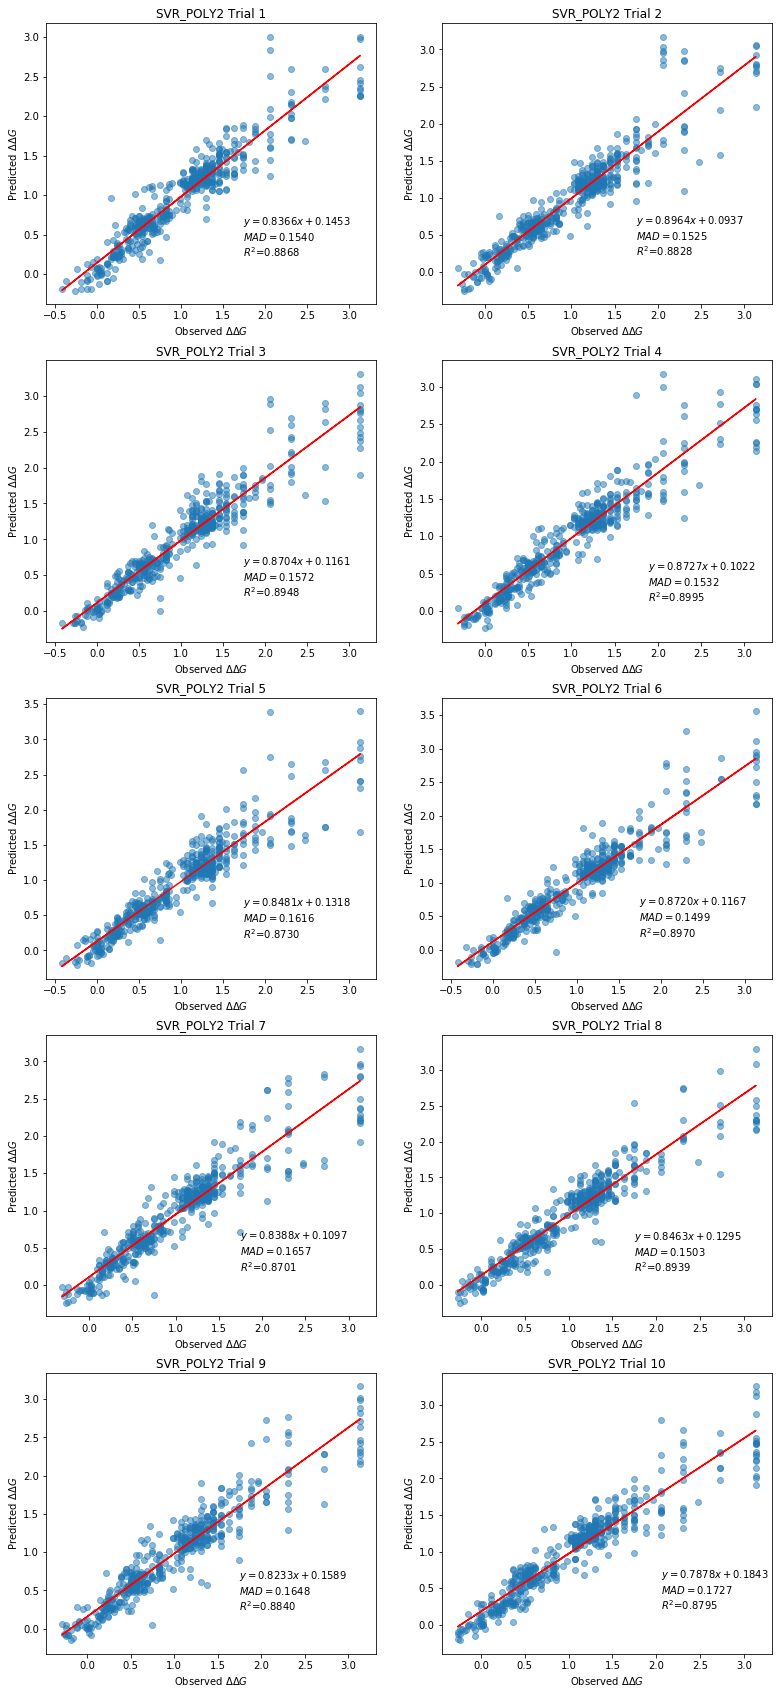

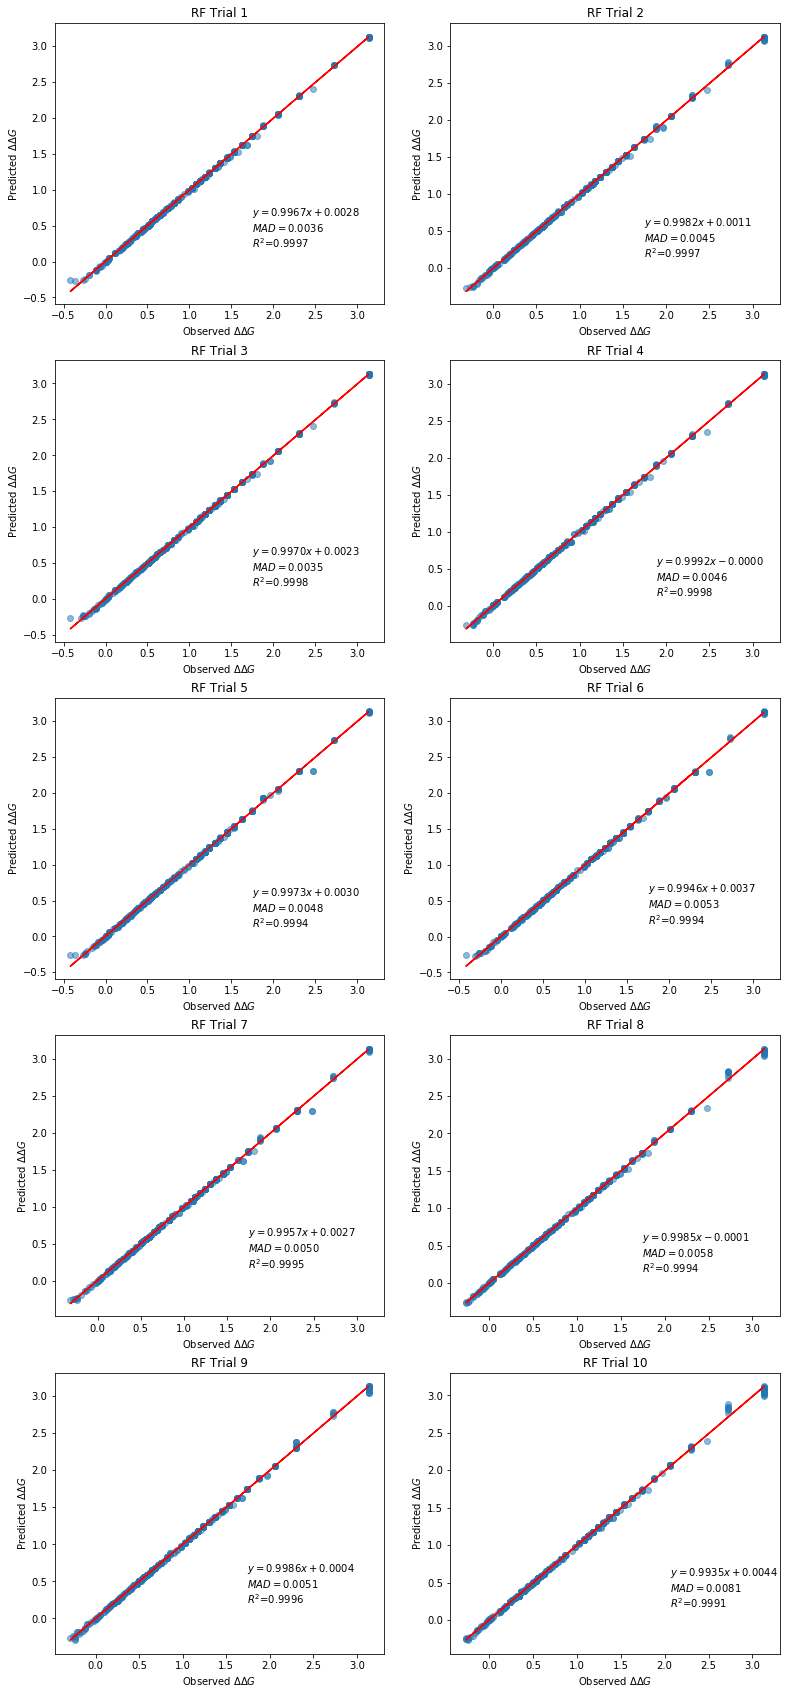

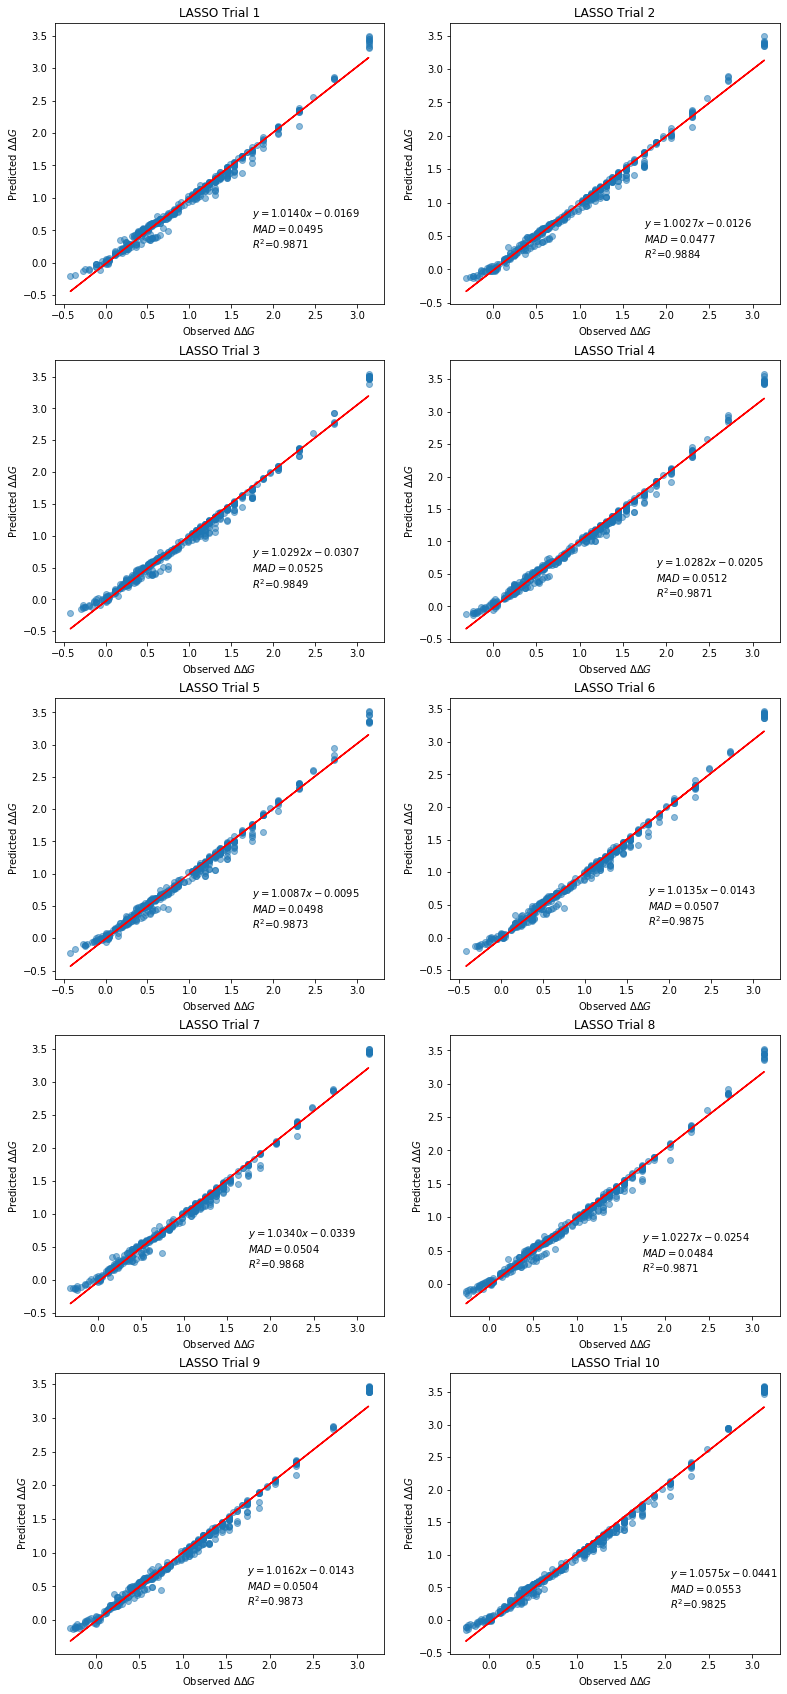

In [4]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def R_square(y, y_hat):
    y_bar = y.mean()
    SSE = ((y - y_hat) ** 2).sum()
    SST = ((y - y_bar) ** 2).sum()
    return 1 - SSE / SST

with open("./RandomSplit/results.pickle", "rb") as f:
    results = pickle.load(f)

writer = pd.ExcelWriter("./CaseStudy-Fig6/Results.xlsx") 
for model in results.keys():
    datas = results[model]
    res = {}
    fig, axes = plt.subplots(5, 2, figsize=(13, 30))
    for i in range(10):
        ax = axes[i // 2][i % 2]
        data = datas[i]
        MAD = abs(data["test_ddG"] - data["predict_ddG"]).mean()
        popt, pcov = curve_fit(lambda x, a, b: a + b * x, data['test_ddG'], data["predict_ddG"])
        regression = "y = {:-.4f}x{:+.4f}".format(popt[1], popt[0])
        R_2 = R_square(data["test_ddG"], data["predict_ddG"])
        res[f"Trial {i+1}"] = {"MAD": MAD, "R^2": R_2, "Regression": regression}
        ax.scatter(data["test_ddG"], data["predict_ddG"], marker="o", alpha=0.5)
        ax.plot(data["test_ddG"], popt[0] + popt[1] * data["test_ddG"], color="red")
        ax.set_title(f"{model} Trial {1+i}")
        ax.set_xlabel(r"Observed $\Delta \Delta G$")
        ax.set_ylabel(r"Predicted $\Delta \Delta G$")
        ax.text(np.percentile(data["test_ddG"], 90), np.percentile(data["predict_ddG"], 10),
                "${}$\n$MAD={:.4f}$\n$R^2$={:.4f}".format(regression, MAD, R_2))
    plt.savefig(f"./CaseStudy-Fig6/{model}.png", dpi=300)
    df = pd.DataFrame(res)
    df.to_excel(writer, sheet_name=model)
writer.save()

### JACS-CaseStudy1

,R^2,MAD_train,MAD_cat,MAD_subs,MAD_catsubs,MAD_test
RF,0.998831,0.003923,0.010213,0.008369,0.014030,0.010581
LASSO,0.985315,0.056748,0.068799,0.051068,0.061846,0.061536
RIDGE,0.975418,0.048855,0.063273,0.110866,0.129651,0.094577
LASSOLARS,0.981405,0.062772,0.067018,0.059401,0.066443,0.064495
SVR_POLY2,0.414743,0.325996,0.483120,0.324048,0.528477,0.444620
SVR_RBF,0.939576,0.021086,0.063387,0.138900,0.204196,0.121837
SVR_LINEAR,0.944984,0.051592,0.062700,0.145753,0.171775,0.115654
EN,0.986226,0.050971,0.066738,0.042609,0.055205,0.056341
KR_RBF,0.983131,0.038301,0.092664,0.050366,0.087036,0.078049
KR_LINEAR,-8.868730,0.048897,2.439669,0.473978,3.062535,1.979352


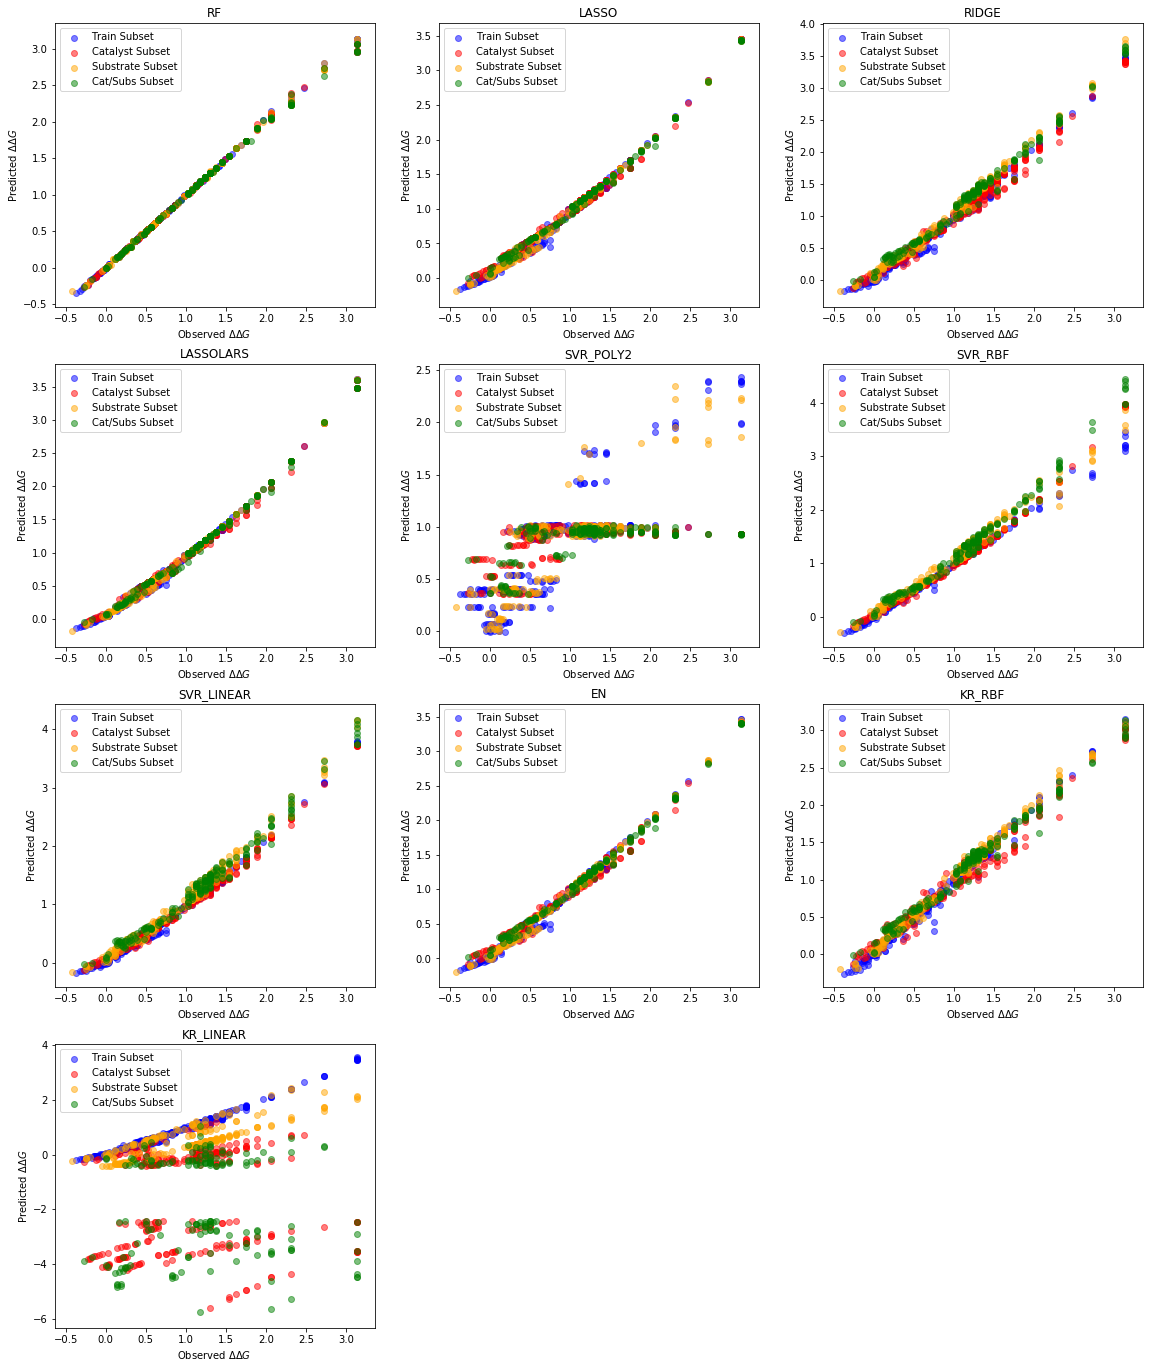

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

with open("./JACS-CaseStudy1/SIF_ESPMAX_FREG500_results.pickle", "rb") as f:
    datas = pickle.load(f)

def MAD(y, y_hat):
    return abs(y_hat - y).mean()

def R_square(y, y_hat):
    y_bar = y.mean()
    SSE = ((y - y_hat) ** 2).sum()
    SST = ((y - y_bar) ** 2).sum()
    return 1 - SSE / SST

models = list(datas.keys())
fig = plt.figure(figsize=(19.5, math.ceil(len(models)/3) * 6))
gs = fig.add_gridspec(math.ceil(len(models)/3), 3)
results = {}
for k in range(len(models)):
    model = models[k]
    data = datas[model]
    observed_train, predict_train = data['train_observed_ddG'], data['train_predict_ddG']
    MAD_train = MAD(observed_train, predict_train)

    observed_cat, predict_cat = data['cat_observed_ddG'], data['cat_predict_ddG']
    MAD_cat = MAD(observed_cat, predict_cat)

    observed_subs, predict_subs = data['subs_observed_ddG'], data['subs_predict_ddG']
    MAD_subs = MAD(observed_subs, predict_subs)

    observed_catsubs, predict_catsubs = data['catsubs_observed_ddG'], data['catsubs_predict_ddG']
    MAD_catsubs = MAD(observed_catsubs, predict_catsubs)
    
    i, j = divmod(k, 3)
    ax = fig.add_subplot(gs[i, j])
    ax.scatter(observed_train, predict_train, color="blue", alpha=0.5, marker='o', label='Train Subset')
    ax.scatter(observed_cat, predict_cat, color="red", alpha=0.5, marker='o', label="Catalyst Subset")
    ax.scatter(observed_subs, predict_subs, color="orange", alpha=0.5, marker='o', label="Substrate Subset")
    ax.scatter(observed_catsubs, predict_catsubs, color="green", alpha=0.5, marker='o', label="Cat/Subs Subset")
    ax.legend()
    ax.set_title(model)
    ax.set_xlabel("Observed $\Delta\Delta G$")
    ax.set_ylabel("Predicted $\Delta\Delta G$")
    
    observed_total = np.concatenate((observed_train, observed_cat, observed_subs, observed_catsubs))
    predict_total = np.concatenate((predict_train, predict_cat, predict_subs, predict_catsubs))
    R_2 = R_square(observed_total, predict_total)
    
    observed_test = np.concatenate((observed_cat, observed_subs, observed_catsubs))
    predict_test = np.concatenate((predict_cat, predict_subs, predict_catsubs))
    MAD_test = MAD(observed_test, predict_test)
    
    results[model] = {"R^2": R_2, "MAD_train": MAD_train, "MAD_cat": MAD_cat,
                      "MAD_subs": MAD_subs, "MAD_catsubs": MAD_catsubs, "MAD_test": MAD_test}

res = pd.DataFrame(results).T
res.to_csv("./JACS-CaseStudy1/SIF_ESPMAX_FRGE500_Results.csv")
plt.savefig("./JACS-CaseStudy1/SIF_ESPMAX_FRGE500_Results.png", dpi=300)
res

,R^2,MAD_train,MAD_cat,MAD_subs,MAD_catsubs,MAD_test
RF,0.997769,0.004466,0.012633,0.012825,0.018028,0.014028
LASSO,0.983305,0.058255,0.066360,0.082309,0.089457,0.077061
RIDGE,0.984014,0.048719,0.062675,0.052502,0.068200,0.060862
LASSOLARS,0.980017,0.052743,0.067355,0.061696,0.074877,0.067448
SVR_POLY2,0.413409,0.328538,0.470732,0.338849,0.521690,0.442117
SVR_RBF,0.971736,0.020639,0.061008,0.069922,0.104560,0.074572
SVR_LINEAR,0.970870,0.051356,0.064203,0.071068,0.083267,0.071067
EN,0.982687,0.052460,0.065049,0.091365,0.097475,0.081300
KR_RBF,0.969165,0.039425,0.096005,0.110314,0.148627,0.113500
KR_LINEAR,-7.830156,0.048718,1.664783,1.416406,3.367015,2.008390


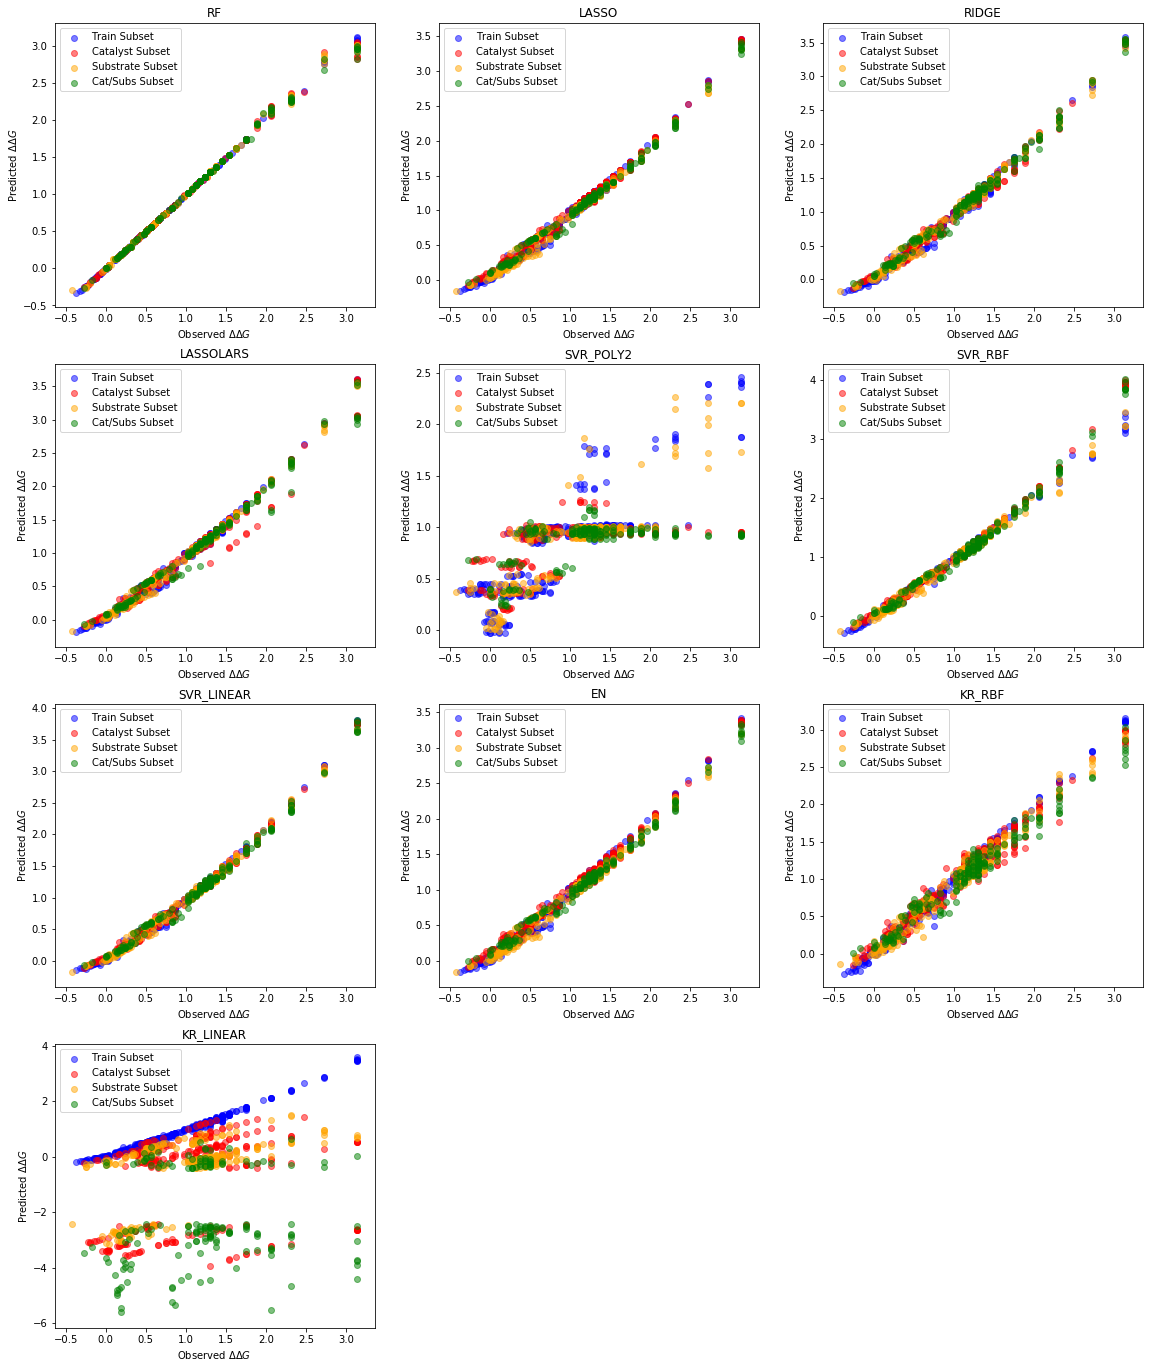

In [6]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

with open("./JACS-CaseStudy1/ASO_ESPMAX_FREG500_results.pickle", "rb") as f:
    datas = pickle.load(f)

def MAD(y, y_hat):
    return abs(y_hat - y).mean()

def R_square(y, y_hat):
    y_bar = y.mean()
    SSE = ((y - y_hat) ** 2).sum()
    SST = ((y - y_bar) ** 2).sum()
    return 1 - SSE / SST

models = list(datas.keys())
fig = plt.figure(figsize=(19.5, math.ceil(len(models)/3) * 6))
gs = fig.add_gridspec(math.ceil(len(models)/3), 3)
results = {}
for k in range(len(models)):
    model = models[k]
    data = datas[model]
    observed_train, predict_train = data['train_observed_ddG'], data['train_predict_ddG']
    MAD_train = MAD(observed_train, predict_train)

    observed_cat, predict_cat = data['cat_observed_ddG'], data['cat_predict_ddG']
    MAD_cat = MAD(observed_cat, predict_cat)

    observed_subs, predict_subs = data['subs_observed_ddG'], data['subs_predict_ddG']
    MAD_subs = MAD(observed_subs, predict_subs)

    observed_catsubs, predict_catsubs = data['catsubs_observed_ddG'], data['catsubs_predict_ddG']
    MAD_catsubs = MAD(observed_catsubs, predict_catsubs)
    
    i, j = divmod(k, 3)
    ax = fig.add_subplot(gs[i, j])
    ax.scatter(observed_train, predict_train, color="blue", alpha=0.5, marker='o', label='Train Subset')
    ax.scatter(observed_cat, predict_cat, color="red", alpha=0.5, marker='o', label="Catalyst Subset")
    ax.scatter(observed_subs, predict_subs, color="orange", alpha=0.5, marker='o', label="Substrate Subset")
    ax.scatter(observed_catsubs, predict_catsubs, color="green", alpha=0.5, marker='o', label="Cat/Subs Subset")
    ax.legend()
    ax.set_title(model)
    ax.set_xlabel("Observed $\Delta\Delta G$")
    ax.set_ylabel("Predicted $\Delta\Delta G$")
    
    observed_total = np.concatenate((observed_train, observed_cat, observed_subs, observed_catsubs))
    predict_total = np.concatenate((predict_train, predict_cat, predict_subs, predict_catsubs))
    R_2 = R_square(observed_total, predict_total)
    
    observed_test = np.concatenate((observed_cat, observed_subs, observed_catsubs))
    predict_test = np.concatenate((predict_cat, predict_subs, predict_catsubs))
    MAD_test = MAD(observed_test, predict_test)
    
    results[model] = {"R^2": R_2, "MAD_train": MAD_train, "MAD_cat": MAD_cat,
                      "MAD_subs": MAD_subs, "MAD_catsubs": MAD_catsubs, "MAD_test": MAD_test}

res = pd.DataFrame(results).T
res.to_csv("./JACS-CaseStudy1/ASO_ESPMAX_FRGE500_Results.csv")
plt.savefig("./JACS-CaseStudy1/ASO_ESPMAX_FRGE500_Results.png", dpi=300)
res

### JACS-CaseStudy3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from data_prepare import *
from scipy.special import inv_boxcox
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
import math
import sys

In [2]:
reactions = pd.read_csv("Reaction_data.csv")["Reaction"]

train_catalysts = ["182_i", "181_i", "207_i", "242_i",
                   "99_vi", "246_vi", "251_vi", "253_i",
                   "276_i", "286_vi", "71_vi", "76_vi"]
train_combs = ["{}_{}_{}".format(c, i, t) for c in train_catalysts for i in [1, 2]  for t in ["A", "B", "C"]]
test_combs = [reaction for reaction in reactions if reaction not in train_combs]

descriptors = ["ASO", "ESPMAX"]
raw_data = load_raw_data(descriptors, origin="Denmark", scale=True, boxcox_=True)

data = load_data(raw_data, train_combs, test_combs, feature_selection="PCA", n_features=50)
# data = load_data(raw_data, train_combs, test_combs)

# LassoCV - feature selection
# model = LassoCV(cv=15, max_iter=1000000, n_jobs=-1)
# model.fit(data['train_X'], data['train_Y'])

# mask = list(np.arange(len(model.coef_))[model.coef_ != 0])

# data['train_X'] = data['train_X'][:, mask]
# data['test_X'] = data['test_X'][:, mask]

data['train_X'].shape

(72, 50)

,PLS3,RF,SVR_RBF
q^2,0.122187,-0.718802,-1.165550
Train R^2,0.866262,0.942401,0.943846
Test R^2,0.465843,0.147363,-0.026717
Train MAD,0.179604,0.093209,0.140656
Test MAD,0.391768,0.449643,0.565399


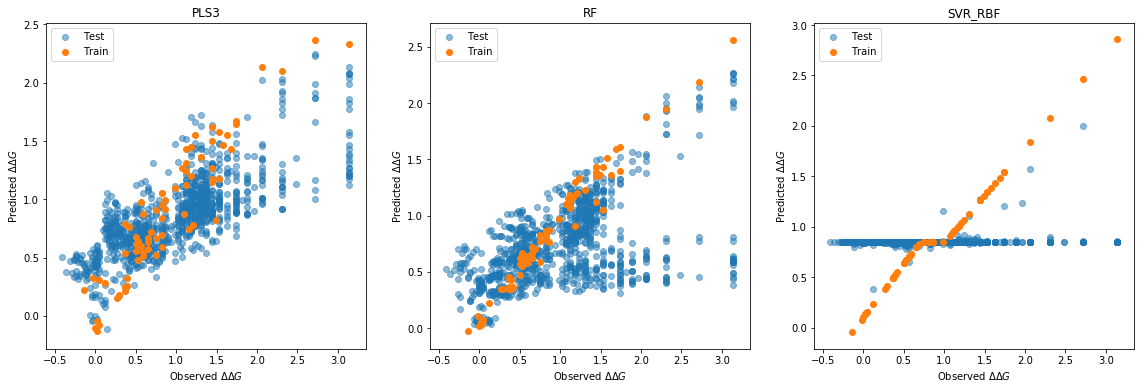

In [3]:
models = {}
models["SVR_RBF"] = SVR(kernel='rbf', C=300, gamma=0.01, epsilon=0.075)
models["RF"] = RFR(n_estimators=20, max_features=0.2, max_depth=8)
models["PLS3"] = PLSRegression(n_components=3, scale=False)

metrics = {}
results = {}

keys = list(models.keys())
keys.sort()

for key in keys:
    model = models[key]
    q2 = cross_val_score(model, data['train_X'], data['train_Y'], scoring='r2', cv=5).mean()
    
    model.fit(data['train_X'], data['train_Y'])
    
    pred_train_Y = model.predict(data['train_X'])
    pred_test_Y = model.predict(data['test_X'])
    
    if data['lambda']:
        pred_train_ddG = inv_boxcox(abs(pred_train_Y), data['lambda']) * np.sign(pred_train_Y) - data['shift']
        pred_test_ddG = inv_boxcox(abs(pred_test_Y), data['lambda']) * np.sign(pred_test_Y) - data['shift']
    else:
        pred_train_ddG = pred_train_Y.copy()
        pred_test_ddG = pred_test_Y.copy()

    train_r2 = r2_score(data['train_ddG'], pred_train_ddG)
    test_r2 = r2_score(data['test_ddG'], pred_test_ddG)
    
    train_MAD = mean_absolute_error(data['train_ddG'], pred_train_ddG)
    test_MAD = mean_absolute_error(data['test_ddG'], pred_test_ddG)
    
    metrics[key] = {"q^2": q2, "Train R^2": train_r2, "Test R^2": test_r2, "Train MAD": train_MAD, "Test MAD": test_MAD}
    results[key] = {"train": {"Observed": data['train_ddG'], "Predict": pred_train_ddG, "combs": data['train_combs']},
                    "test": {"Observed": data['test_ddG'], "Predict": pred_test_ddG, "combs": data['test_combs']}}

# write to excel

writer = pd.ExcelWriter("./JACS-CaseStudy3/Results.xlsx")
pd.DataFrame(metrics).to_excel(writer, sheet_name="metrics")

train = pd.DataFrame(index=data['train_combs'])
test = pd.DataFrame(index=data['test_combs'])
for key in keys:
    train["{}_Observed".format(key)] = results[key]['train']["Observed"]
    train["{}_Predict".format(key)] = results[key]['train']["Predict"]
    test["{}_Observed".format(key)] = results[key]['test']["Observed"]
    test["{}_Predict".format(key)] = results[key]['test']["Predict"]
train.to_excel(writer, sheet_name="Train")
test.to_excel(writer, sheet_name="Test")
writer.save()

# Plot
fig = plt.figure(figsize=(19.5, math.ceil(len(models)/3) * 6))
gs = gridspec.GridSpec(nrows=int(math.ceil(len(models)/3)), ncols=3, figure=fig)

for k in range(len(keys)):
    key = keys[k]
    i, j = divmod(k, 3)
    ax = fig.add_subplot(gs[i, j])
    ax.set_title(key)
    ax.scatter(results[key]["test"]["Observed"], results[key]["test"]["Predict"], marker='o', color="C0", alpha=0.5, label="Test")
    ax.scatter(results[key]["train"]["Observed"], results[key]["train"]["Predict"], marker='o', color="C1", alpha=1, label="Train")
    ax.legend()
    ax.set_xlabel("Observed $\Delta\Delta G$")
    ax.set_ylabel("Predicted $\Delta\Delta G$")

plt.savefig("./JACS-CaseStudy3/fig.png", dpi=300)
pd.DataFrame(metrics)